In [1]:
import numpy as np
import random
import torch
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import test as test
model_file="test.pt"
epochs=100
patience = 5
best_loss = float('inf')
counter = 0

In [3]:
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914,0.4822,0.4465),
        std=(0.2470,0.2435,0.2616))
])

In [5]:
train_data=datasets.CIFAR10('data/cifar10/train',train=True,download=True,transform=transform)
print(train_data.data.shape)

Files already downloaded and verified


(50000, 32, 32, 3)


In [6]:
dev_size=0.2
idx=list(range(len(train_data)))
np.random.shuffle(idx)
split_size=int(np.floor(dev_size*len(train_data)))
train_idx, dev_idx=idx[split_size:], idx[:split_size]
train_sampler=SubsetRandomSampler(train_idx)
dev_sampler=SubsetRandomSampler(dev_idx)

In [7]:
batch_size=100
train_loader= DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
dev_loader= DataLoader(train_data,batch_size=batch_size,sampler=dev_sampler)
print(len(train_loader),len(dev_loader))

400 100


In [8]:
data_batch,label_batch=next(iter(train_loader))
print(data_batch.size(),label_batch.size())

torch.Size([100, 3, 32, 32]) torch.Size([100])


In [9]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"deivce:{device}")

deivce:cuda


In [10]:
model=test.ResNet18().to(device)

In [11]:
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)

In [12]:
train_losses=[]
dev_losses=[]
x_axis=[]
lr = 0.01

for epoch in range(epochs+1):
    train_loss=0
    # 訓練資料
    model.train()
    for data,target in tqdm(train_loader):        
        data=data.to(device)
        target=target.to(device)
        
        pred=model(data)
        loss=loss_function(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    
    x_axis.append(epoch)
    with torch.no_grad():
        dev_loss=0
        # 驗證資料
        model.eval()
        for data_dev,target_dev in tqdm(dev_loader):               
            data_dev=data_dev.to(device)
            target_dev=target_dev.to(device)

            dev_pred=model(data_dev)
            loss2=loss_function(dev_pred,target_dev)
            dev_loss += loss2.item()

        dev_loss=dev_loss/len(dev_loader)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    print(f"epoch: {epoch}, Train_loss: {train_loss:.3f}, Valid_loss: {dev_loss:.3f}, lr: {lr}")
    
    # 每10個epoch降低2倍lr
    # if epoch % 10 == 0 and epoch > 0:
    #     lr /= 2
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = lr
    
    if dev_loss < best_loss:
        best_loss = dev_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience and epoch > 50:
            print('Early stopping at epoch', epoch)
            break

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 40.60it/s]


NameError: name 'scheduler' is not defined

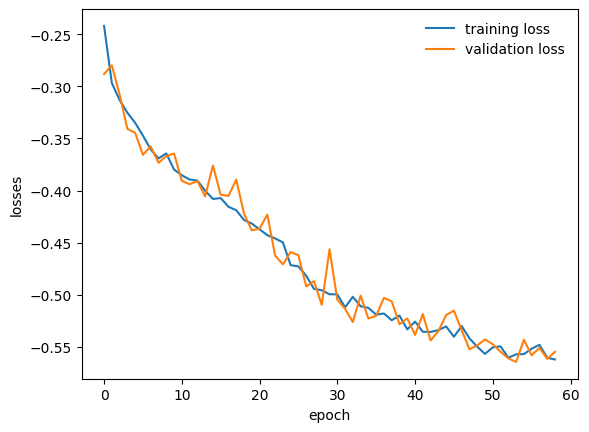

In [ ]:
plt.plot(x_axis,train_losses,label="training loss")
plt.plot(x_axis,dev_losses,label="validation loss")
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

In [ ]:
model=model.to("cpu")
torch.save(model.state_dict(),model_file)